# Duc Huy Nguyen - Statistics DRP Project Autumn 2025
## Relationship between Job Postings and Unemployment
### with related Economics metrics

We first import the required libraries for the project

In [155]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.interpolate import CubicSpline

# Import some ML models from pygam and 
from pygam import LinearGAM, s, f, l
# By default, spline terms, s() have a penalty on their 2nd derivative, 
# which encourages the functions to be smoother, while factor terms, 
# f() and linear terms l(), have a l2, i.e. ridge penalty, which encourages them to take on smaller values.
from sklearn.metrics import mean_squared_error, accuracy_score
import sklearn.model_selection as skm 
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.svm import SVC

# Use external library to plot our decision regions
from mlxtend.plotting import plot_decision_regions


In [156]:
# Suppress irrelevant warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(
    "ignore",
    message="KNOWN BUG: p-values computed in this summary are likely much smaller than they should be.",
    category=UserWarning
)

## Loading data and preliminary processing
We then load relevant datasets on job postings, unemployment, interest rates, inflation, stock prices and GDP into our notebook.

In [157]:
natural_unemp_df = pd.read_csv('Data/quarterly_natural_unemp.csv')
unemp_df = pd.read_csv('Data/monthly_unemployment_rate.csv') # Read Unemployment data
cpi_df = pd.read_csv('Data/monthly_cpi.csv') # Read CPI data
gdp_df = pd.read_csv('Data/quarterly_gdp.csv')# Read GDP data
job_df = pd.read_csv('Data/monthly_job_postings.csv')# Read Job Postings
sp500_df = pd.read_csv('Data/monthly_sp500.csv') # Read S&P 500 data
bond_df = pd.read_csv('Data/monthly_bonds.csv') # Read the bonds data
inflation_df = pd.read_csv('Data/monthly_inflation_rate.csv')
interest_df = pd.read_csv('Data/monthly_federal_funds_rate.csv') # Read the interest rates data

We format the time for our Dataframe 

In [158]:
for df in [natural_unemp_df, cpi_df, gdp_df, bond_df, unemp_df, interest_df, job_df, inflation_df]: # format dates for data got from FRED
    df.rename(columns={'observation_date' : 'date'}, inplace=True)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

We then format the monthly stock price

In [159]:
for df in [sp500_df]:
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

In [160]:
# Resample the bonds returns
bond_df = bond_df.resample('MS').first()

### Estimating quarterly GDP from monthly GDP through interpolation

We then try to estimate the monthly GDP data using resampling and interpolation in Python.  
We are using linear spline to predict the months within 2025 Q3 without available data (this would be updated by FRED in Nov 26th 2025)

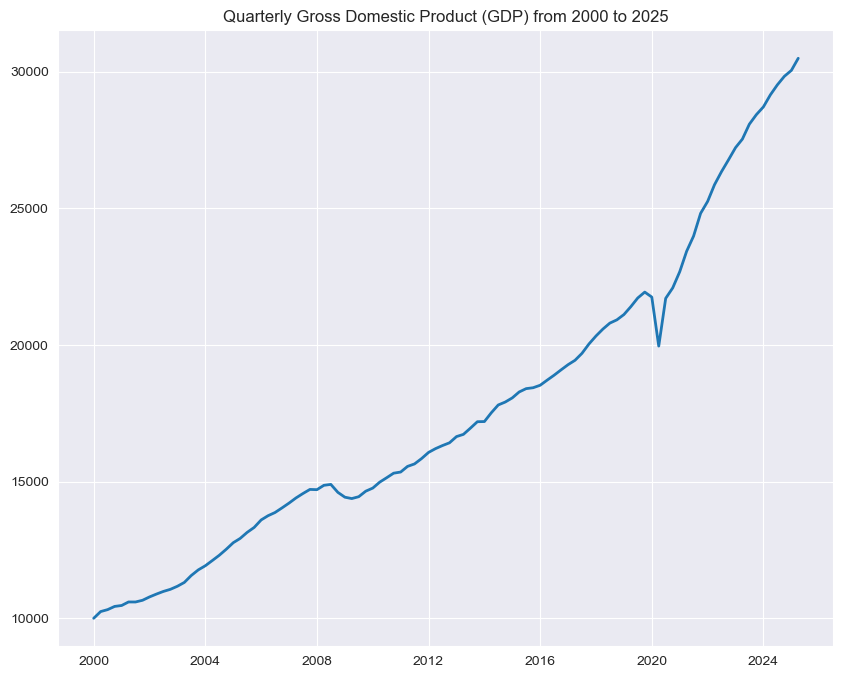

In [161]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Quarterly Gross Domestic Product (GDP) from 2000 to 2025')
plt.show()

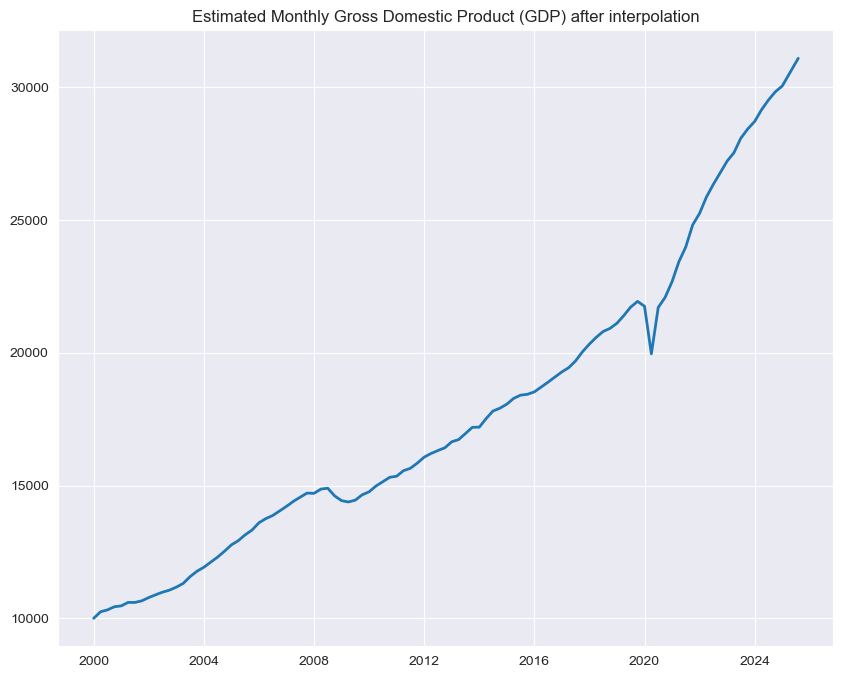

In [162]:
# We extend our current date time into the future
future_dates = pd.to_datetime(['2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01'])
extended_index = gdp_df.index.union(future_dates)

# print(extended_index)
gdp_df = gdp_df.reindex(extended_index)

# Then we interpolate the data 
gdp_df = gdp_df.resample('MS')
gdp_df = gdp_df.interpolate(method='spline', order = 1)

# Check the data after interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(gdp_df.index, gdp_df['GDP'], linewidth=2, markersize=12)
plt.title('Estimated Monthly Gross Domestic Product (GDP) after interpolation')
plt.show()

### Estimating the monthly Natural Unemployment rate from quarterly rate


We then try to estimate the monthly natural rate of unemployment (NAIRU) data using resampling and interpolation in Python.  


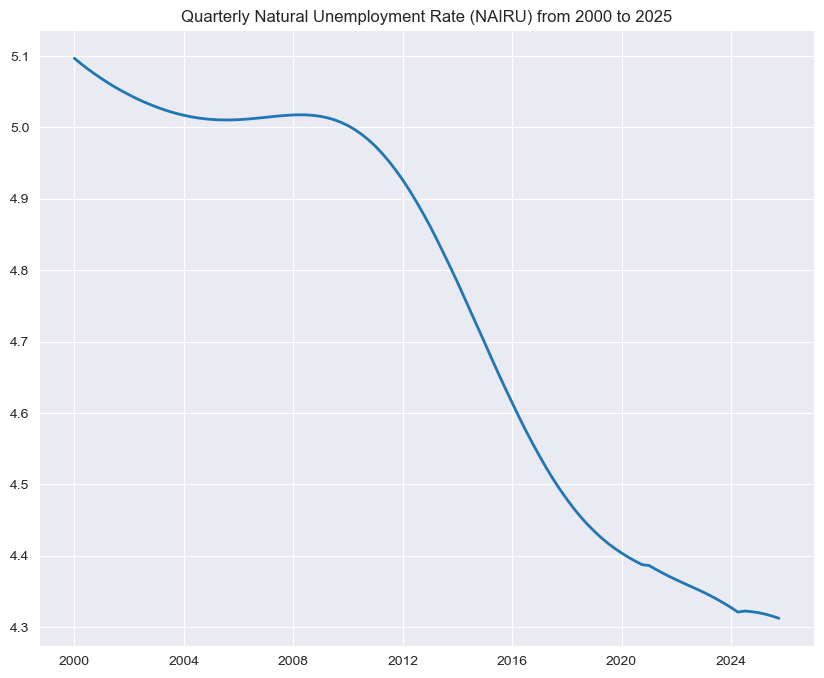

In [163]:
# First we plot the data before interpolation
fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], linewidth=2, markersize=12)
plt.title('Quarterly Natural Unemployment Rate (NAIRU) from 2000 to 2025')
plt.show()

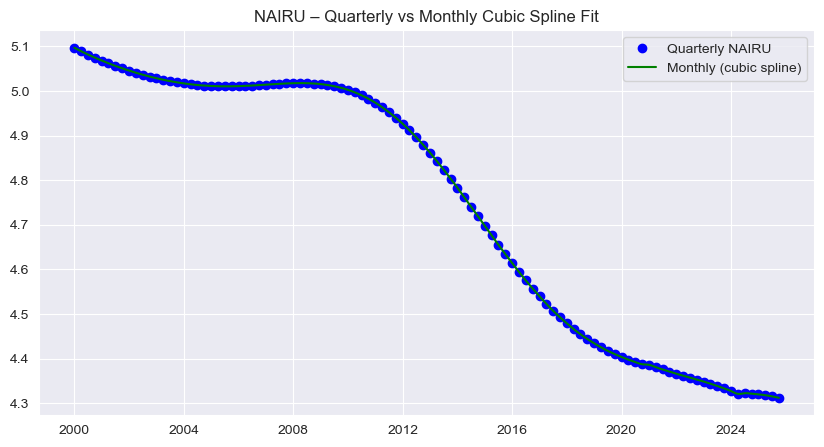

In [164]:
# With the pattern being represented, we use cubic spline interpolation to fit monthly data
# We interpolate the data 
# natural_unemp_df = natural_unemp_df.resample('MS')

# cubic spline with “natural” boundary conditions to reduce edge wiggles
cs = CubicSpline(natural_unemp_df.index.view('int64'), natural_unemp_df['NROU'], bc_type='natural')

# monthly dates from first to last quarter
monthly_natural_unemp_df = natural_unemp_df.resample('MS').first()
x_m = monthly_natural_unemp_df.index.view('int64')

nairu_monthly_cs = pd.DataFrame(cs(x_m), 
        index=monthly_natural_unemp_df.index, 
        columns=['NROU']
)

plt.figure(figsize=(10, 5))
plt.plot(natural_unemp_df.index, natural_unemp_df['NROU'], 'o', color='blue', label='Quarterly NAIRU')
plt.plot(nairu_monthly_cs.index, nairu_monthly_cs['NROU'], color='green', label='Monthly (cubic spline)')
plt.legend()
plt.title('NAIRU – Quarterly vs Monthly Cubic Spline Fit')
plt.show()

natural_unemp_df = nairu_monthly_cs.copy()

## Data Cleaning and Formatting 

In [165]:
print(cpi_df.head(5))
print(unemp_df.head(5))
print(job_df.head(5))
print(sp500_df.head(5))
print(bond_df.head(5))
print(interest_df.head(5))
print(gdp_df.head(5))
print(natural_unemp_df.head(5))

            CPIAUCSL
date                
2000-01-01     169.3
2000-02-01     170.0
2000-03-01     171.0
2000-04-01     170.9
2000-05-01     171.2
            UNRATE
date              
2000-01-01     4.0
2000-02-01     4.1
2000-03-01     4.0
2000-04-01     3.8
2000-05-01     4.0
            JTSJOL
date              
2000-12-01    5088
2001-01-01    5234
2001-02-01    5097
2001-03-01    4762
2001-04-01    4615
                  SPY
date                 
1999-08-01  82.999374
1999-09-01  81.145393
1999-10-01  86.345009
1999-11-01  87.782784
1999-12-01  92.795937
            DGS10
date             
2000-01-01   6.58
2000-02-01   6.62
2000-03-01   6.39
2000-04-01   6.00
2000-05-01   6.29
            FEDFUNDS
date                
2000-01-01      5.45
2000-02-01      5.73
2000-03-01      5.85
2000-04-01      6.02
2000-05-01      6.27
                     GDP
2000-01-01  10002.179000
2000-02-01  10085.816288
2000-03-01  10163.985130
2000-04-01  10247.720000
2000-05-01  10270.876805
          

In [166]:
# Sanity check on the index type
assert (type(job_df.index) == type(sp500_df.index) == type(inflation_df.index)
        == type(cpi_df.index) == type(unemp_df.index)
        == type(gdp_df.index) == type(interest_df.index)
        == type(natural_unemp_df.index) == type(bond_df.index) == pd.DatetimeIndex)


In [167]:
# Count the number of Nan values
print(cpi_df.isna().sum())
print(unemp_df.isna().sum())
print(job_df.isna().sum())
print(sp500_df.isna().sum())
print(interest_df.isna().sum())
print(bond_df.isna().sum())
print(gdp_df.isna().sum())
print(inflation_df.isna().sum())

CPIAUCSL    0
dtype: int64
UNRATE    0
dtype: int64
JTSJOL    0
dtype: int64
SPY    0
dtype: int64
FEDFUNDS    0
dtype: int64
DGS10    0
dtype: int64
GDP    0
dtype: int64
T10YIEM    0
dtype: int64


In [168]:
# Include another Dummy Variables for which Party is winning presidency
dates = pd.date_range(start = "2000-10-01", end = "2025-08-01", freq = "MS")

# Determine the presidency 
def president_party(date):
    if (date < pd.Timestamp("2000-01-20")  # Bill Clinton
            or pd.Timestamp("2009-01-20") < date < pd.Timestamp("2017-01-20") # Obama
            or pd.Timestamp("2021-01-20") < date < pd.Timestamp("2025-01-20")): # Biden
        return "Dem"
    else:
        return "Rep"
    
party_df = pd.DataFrame({
    "date": dates,
    "party": [president_party(d) for d in dates]
})

# Dummy variable: 1 = Republican, 0 = Democrat
party_df["party"] = (party_df["party"] == "Rep").astype(int)
party_df.set_index('date', inplace = True)

In [169]:
# Join those data together
joined_df = cpi_df.join(unemp_df, how='right')
joined_df = joined_df.join(natural_unemp_df, how='left')
joined_df = joined_df.join(gdp_df, how='left')
joined_df = joined_df.join(job_df, how='left')
joined_df = joined_df.join(inflation_df, how='right')
joined_df = joined_df.join(interest_df, how='left')
joined_df = joined_df.join(bond_df, how='left')
joined_df = joined_df.join(sp500_df, how='inner')
joined_df = joined_df.join(party_df, how='left')

In [170]:
# Rename column names for easier use 
joined_df.rename(columns={
    'NROU' : 'natural_unemp',
    'CPIAUCSL' : 'cpi',
    'UNRATE' : 'unemp',
    'JTSJOL' : 'job_postings',
    'FEDFUNDS' : 'interest_rate',
    'DGS10' : 'bond',
    'SPY' : 'sp500',
    'T10YIEM' : 'inflation_rate'
}, inplace=True)

In [171]:
# Create a new dummy variable for when unemployment rate is above natural rate of unemloyment
joined_df['unemp_higher_than_natural'] = np.where(
    joined_df['unemp'] > joined_df['natural_unemp'],
    1, 0)

## Exploratory Data Analysis

We then examine our datasets before building our machine learning model 

In [172]:
joined_df.head(5)

cpi  unemp  natural_unemp           GDP  job_postings  \
date                                                                  
2003-01-01  182.6    5.8       5.028617  11174.129000        3441.0   
2003-02-01  183.6    5.9       5.027402  11221.893301        3229.0   
2003-03-01  183.9    5.9       5.026332  11265.071833        3099.0   
2003-04-01  183.2    6.0       5.025187  11312.766000        3108.0   
2003-05-01  182.9    6.1       5.024126  11396.520959        3289.0   

            inflation_rate  interest_rate  bond      sp500  party  \
date                                                                
2003-01-01            1.76           1.24  4.07  56.529663      1   
2003-02-01            1.91           1.26  4.01  55.767708      1   
2003-03-01            1.87           1.25  3.68  55.886990      1   
2003-04-01            1.78           1.26  3.84  60.615734      1   
2003-05-01            1.66           1.26  3.88  63.939648      1   

            unemp_higher_than_natural  
date                                   
2003-01-01                          1  
2003-02-01                          1  
2003-03-01                          1  
2003-04-01                          1  
2003-05-01                          1

In [173]:
joined_df.tail(5)

cpi  unemp  natural_unemp           GDP  job_postings  \
date                                                                    
2025-04-01  320.321    4.2       4.318228  30485.729000        7395.0   
2025-05-01  320.580    4.2       4.317423  30633.378449        7712.0   
2025-06-01  321.500    4.1       4.316535  30786.057742        7357.0   
2025-07-01  322.132    4.2       4.315608  30933.811896        7208.0   
2025-08-01  323.364    4.3       4.314575  31086.491188        7227.0   

            inflation_rate  interest_rate  bond       sp500  party  \
date                                                                 
2025-04-01            2.24           4.33  4.17  551.376831      1   
2025-05-01            2.31           4.33  4.25  586.028015      1   
2025-06-01            2.30           4.33  4.46  616.141785      1   
2025-07-01            2.38           4.33  4.26  630.332458      1   
2025-08-01            2.38           4.33  4.23  643.266602      1   

            unemp_higher_than_natural  
date                                   
2025-04-01                          0  
2025-05-01                          0  
2025-06-01                          0  
2025-07-01                          0  
2025-08-01                          0

In [174]:
# Count the number of Nan values
print(joined_df.isna().sum())

cpi                          0
unemp                        0
natural_unemp                0
GDP                          0
job_postings                 0
inflation_rate               0
interest_rate                0
bond                         0
sp500                        0
party                        0
unemp_higher_than_natural    0
dtype: int64


In [175]:
# Total number of observations and date range
print(f'Total number of observations is {len(joined_df)}')
joined_df.index
print(joined_df.columns.tolist())
joined_df.shape

Total number of observations is 272
['cpi', 'unemp', 'natural_unemp', 'GDP', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'unemp_higher_than_natural']


(272, 11)

Sources: Job Postings (in thousands) - From the Bureau of Labor Statistics  
Bonds prices taken from Vanguard's BND which focus on wide spectrum of bonds - Yahoo Finance  
Federal Fund Rate (the rate at which banks with each other at the end of night) - Federal Reserve Bank of ST.LOUIS  
CPI, Unemployment rate, S&P 500 - Federal Reserve Bank of ST.LOUIS

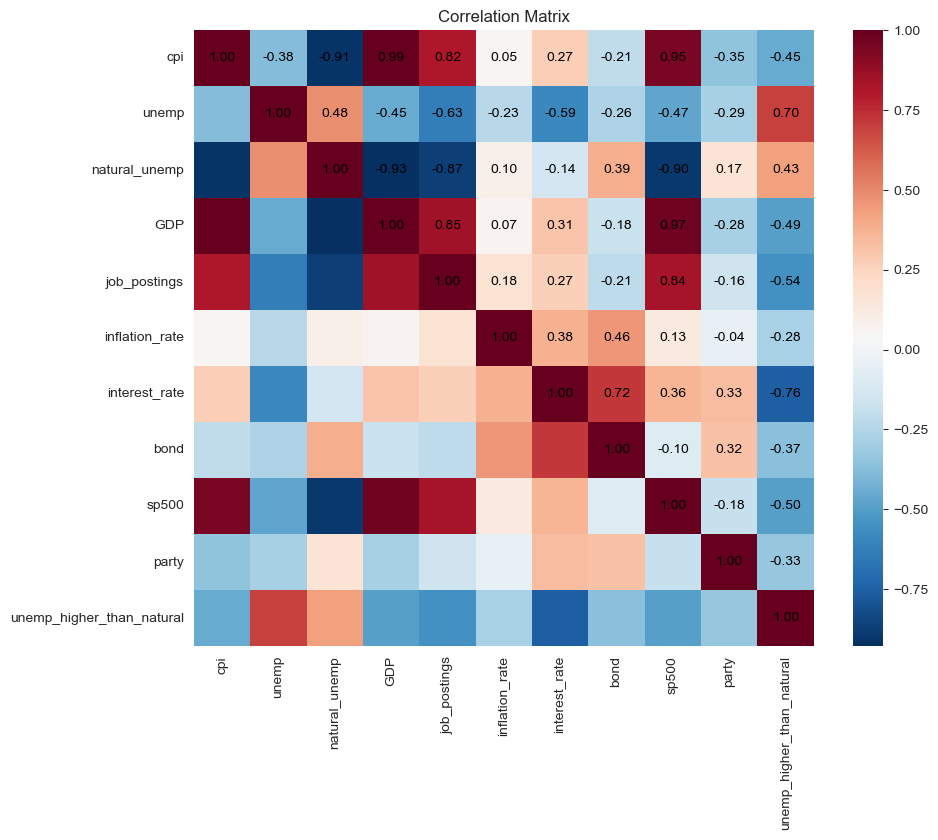

In [176]:
# Explore the correlation between variables
corr_mat = joined_df.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_mat, cmap='RdBu_r', ax=ax, cbar=True)

for i in range(corr_mat.shape[0]):
    for j in range(i, corr_mat.shape[1]): # upper triangle only
        val = corr_mat.iloc[i, j]
        ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                ha="center", va="center", color="black")

ax.set_title("Correlation Matrix")
plt.savefig("Visualizations/CorrMat.png", dpi=300, bbox_inches="tight")
plt.show()

Interestingly, GDP and CPI has the correlation of 1.  
We can also see that GDP and S&P500 has high correlation of 0.98, CPI and S&P500 has high correlation of 0.97  
GDP and job postings also has correlation up to 0.84

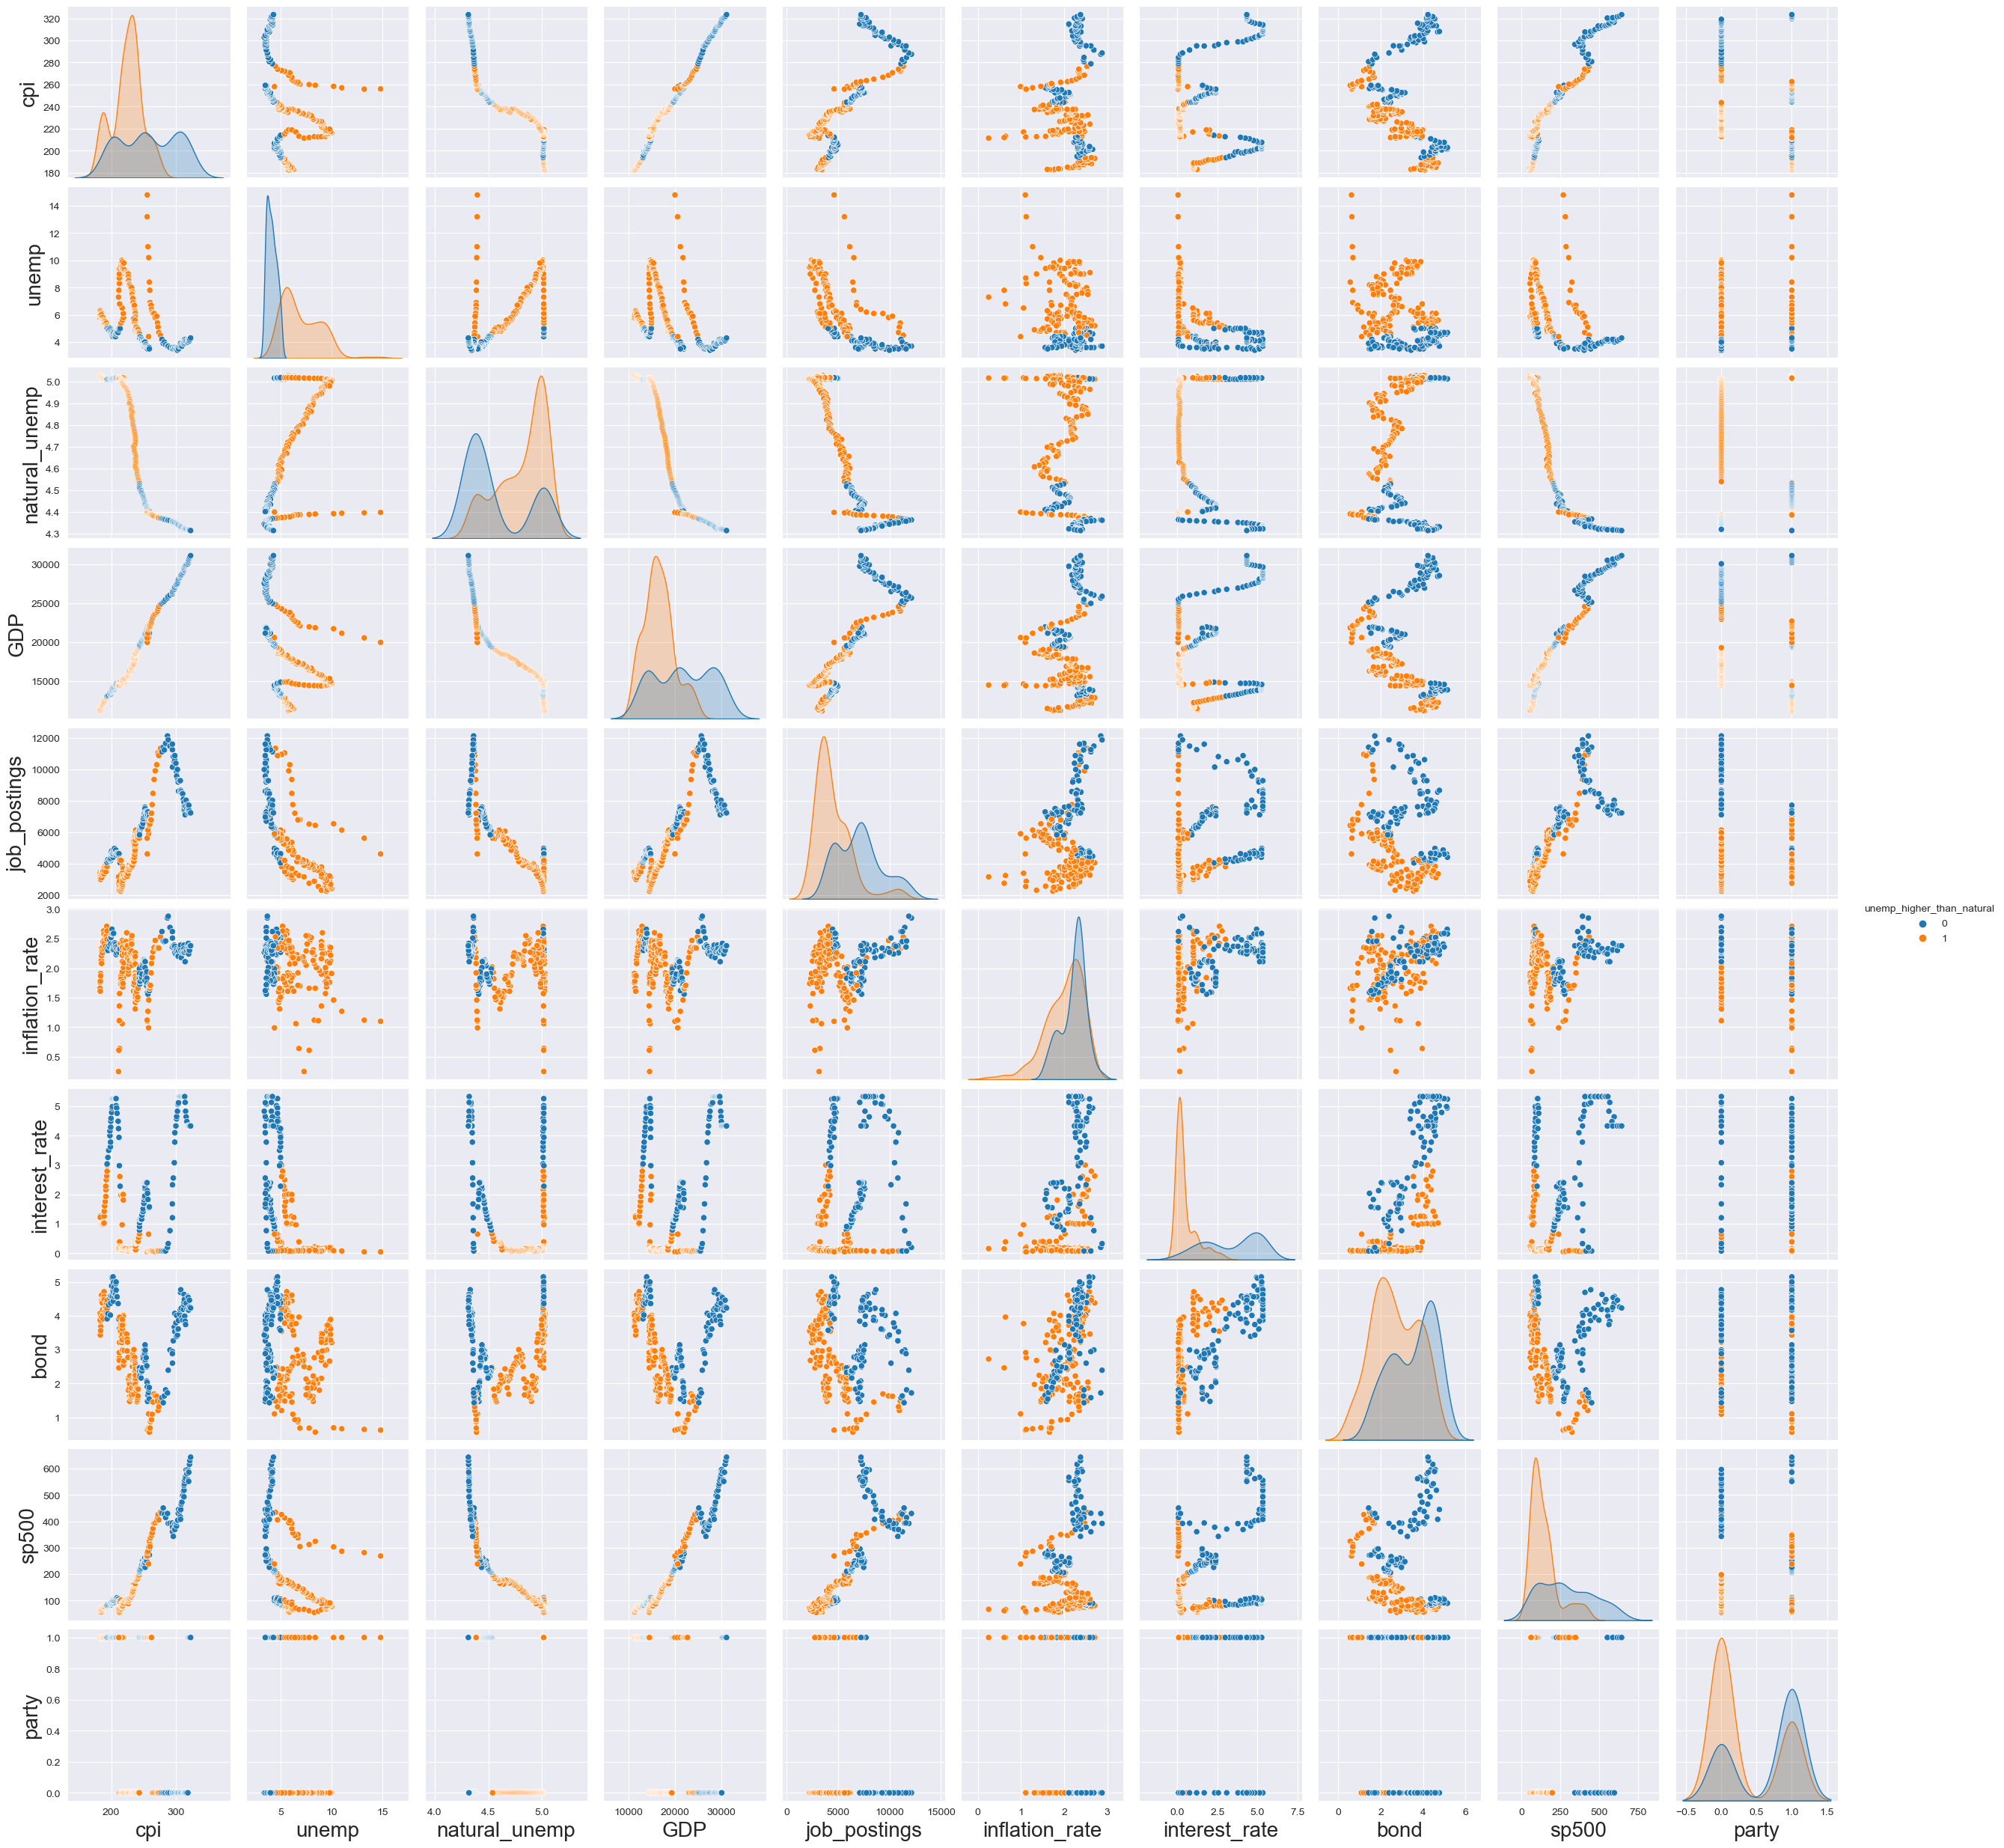

In [177]:
# Pairplots representing the relationships between variables
g = sns.pairplot(joined_df, hue = 'unemp_higher_than_natural')
# Blue for lower, Orange for higher
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig("Visualizations/PairsPlot.png", dpi=300, bbox_inches="tight")
plt.show()

As we can see, the relationship between variables are not linear apart from pairs that have high correlation like CPI and GDP,  
and GDP and SP500

## Fitting Models

In [178]:
# we don't want to transform dummy variables
predictor_columns = ['cpi', 'GDP', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500']
scaler = StandardScaler()

df_scaled = joined_df.copy()
scaler = StandardScaler()

df_scaled[predictor_columns] = scaler.fit_transform(joined_df[predictor_columns])
df_scaled.head(5)
df_scaled.tail(5)
df_scaled.shape

(272, 11)

Since we can see that not all relationship of variables with Unemployment are linear  
and we want to interpret the relationship between Job Postings and Unemployment here  
So we can try Generalized Additive Models before fitting more complex non-parametric methods

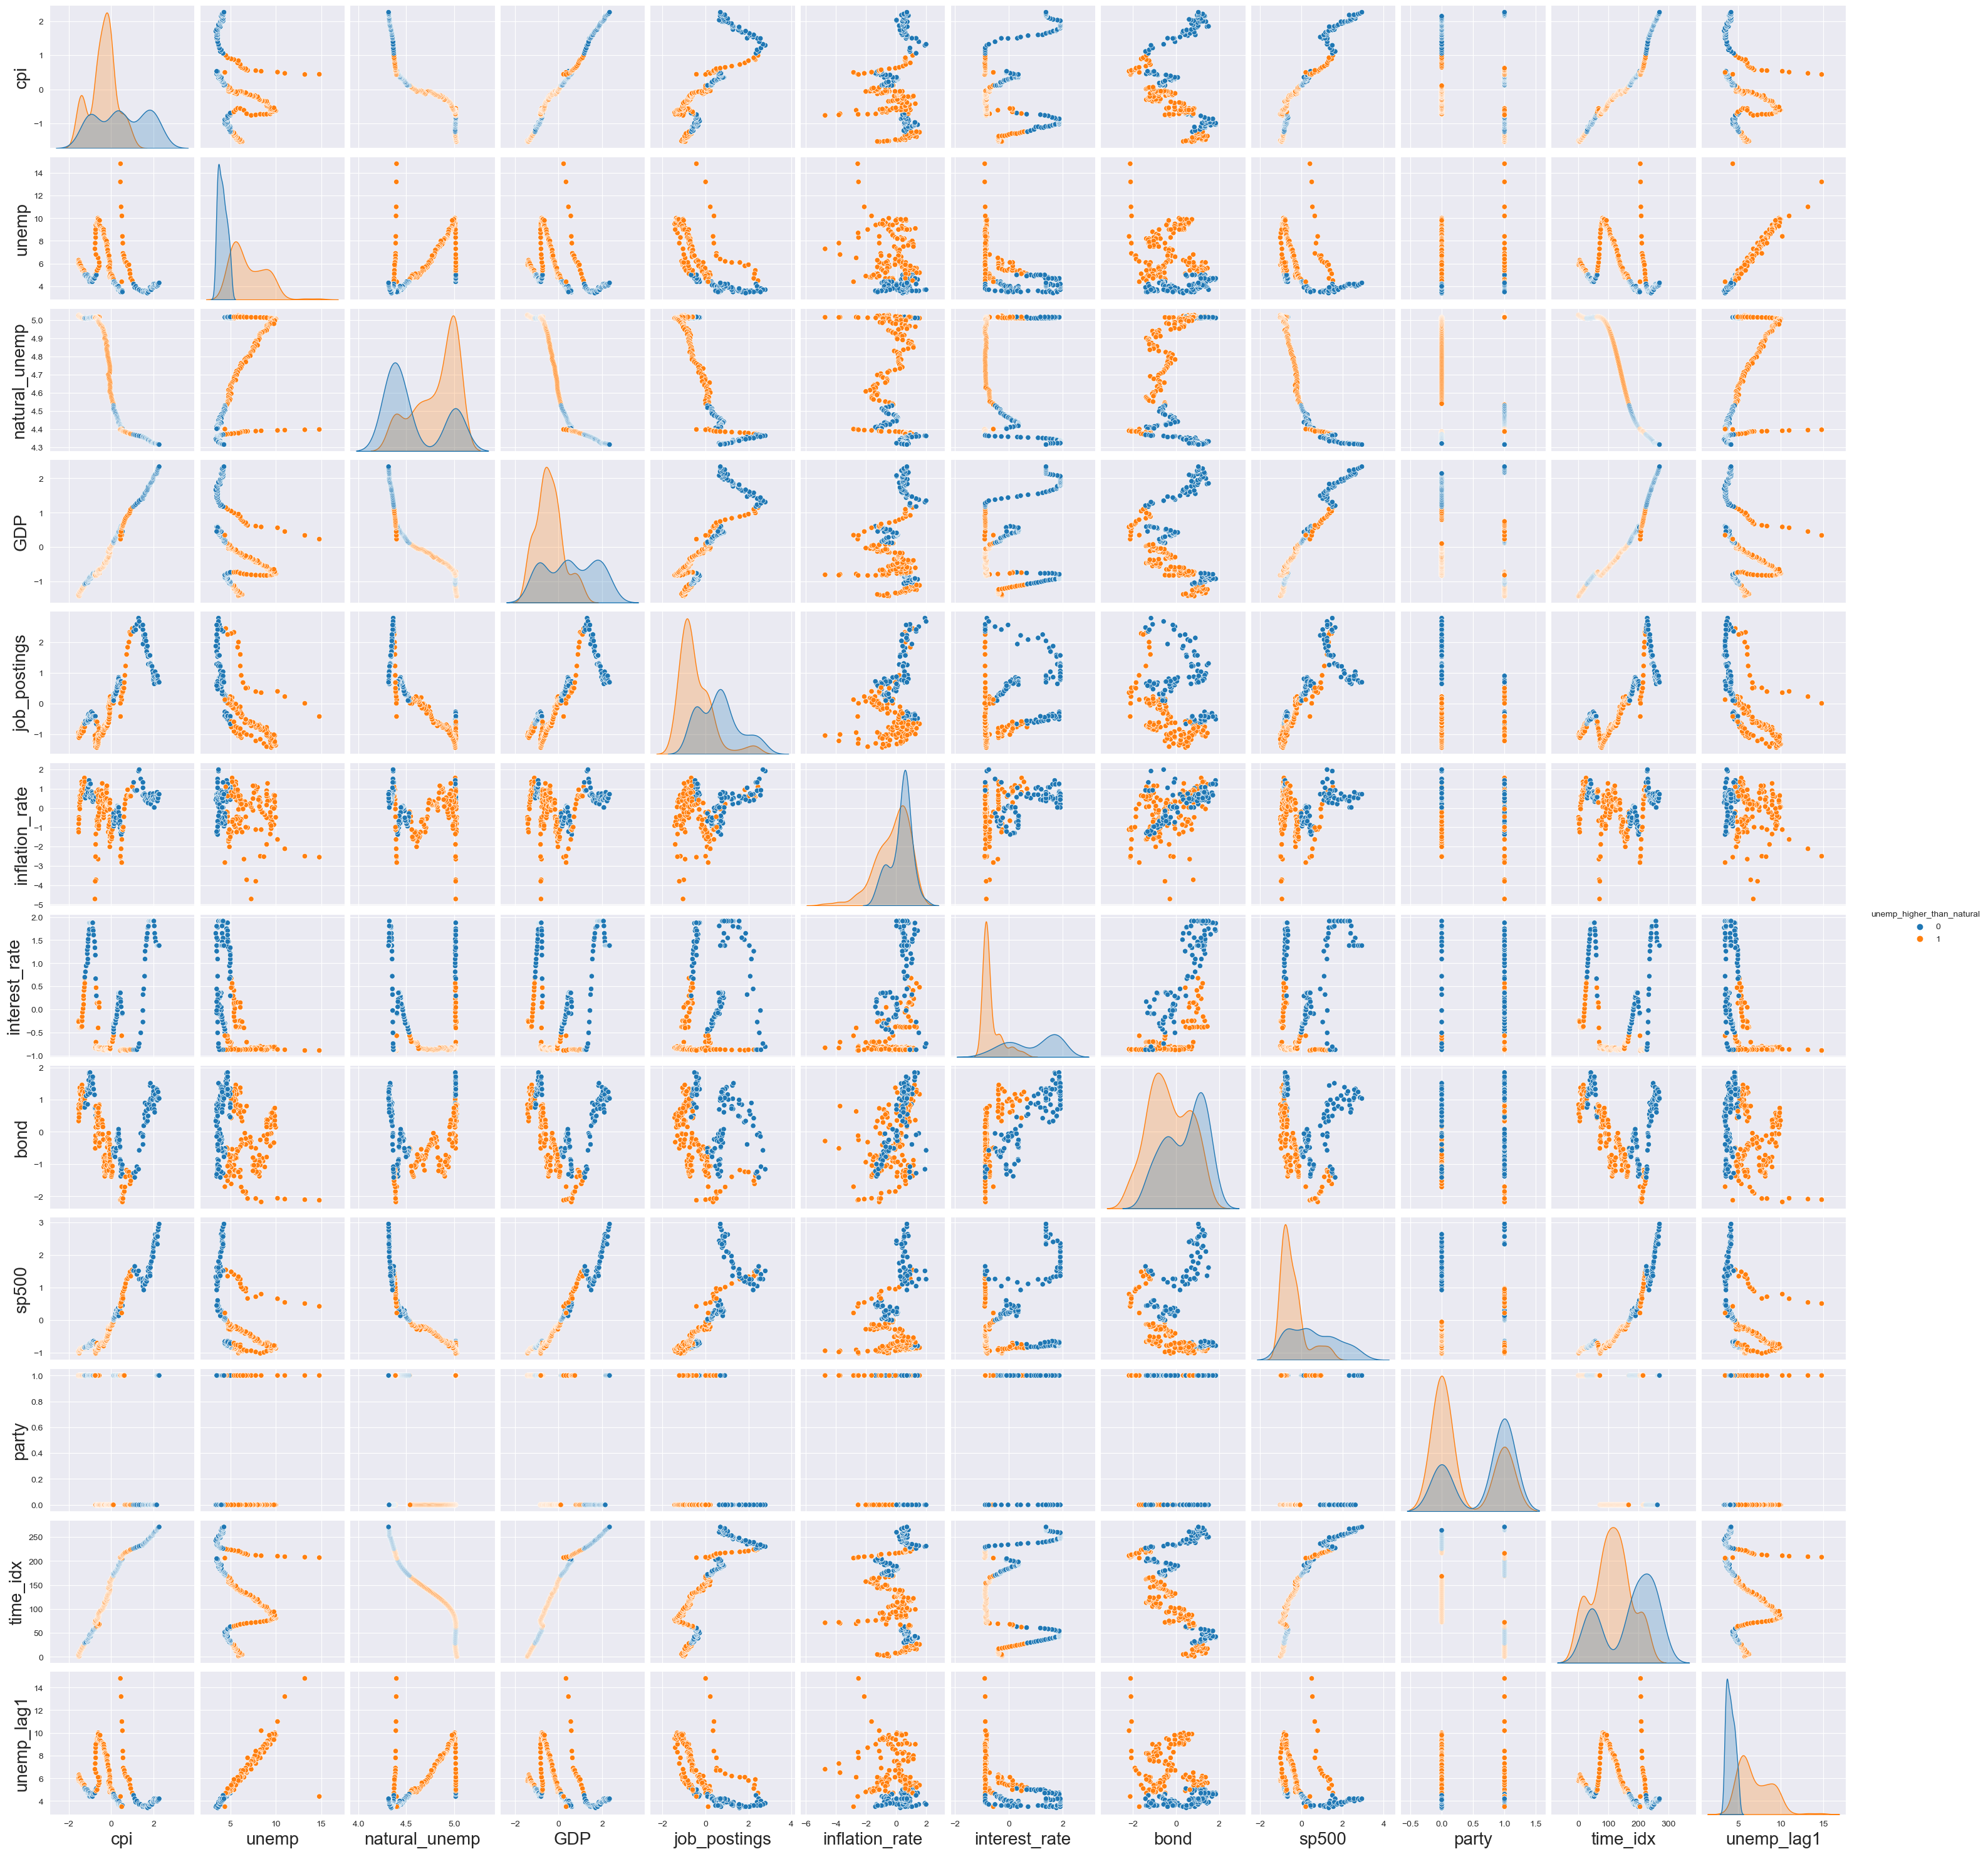

In [179]:
# Splitting the data for training and testing
# We split it at a particular time index for Time Series Data

# Include new variables for time and lag 
time_df = df_scaled.copy()

# time index: 0, 1, 2, ..., T-1
time_df['time_idx'] = np.arange(len(time_df))

# 1-step lag of unemployment
time_df['unemp_lag1'] = time_df['unemp'].shift(1)

# # drop first row where lag is NaN
time_df = time_df.dropna()

time_corr_mat = time_df.corr()

g = sns.pairplot(time_df, hue = 'unemp_higher_than_natural')
# Blue for lower, Orange for higher
for ax in g.axes.flatten():
    ax.set_xlabel(ax.get_xlabel(), fontsize=20)
    ax.set_ylabel(ax.get_ylabel(), fontsize=20)
plt.savefig("Visualizations/PairsPlot_with_time_and_lag.png", dpi=300, bbox_inches="tight")
plt.show()

### Adjustments for Multicollinearity

We realized from our pairs plot and correlation matrix that some predictors are highly correlated i.e. GDP and CPI, GDP and SP500

In [180]:
eigvals, eigvecs = np.linalg.eig(time_corr_mat)

# Sort by largest eigenvalue
order = eigvals.argsort()[::-1]
eigvals = eigvals[order]
eigvecs = eigvecs[:, order]

# Keep proper feature names
eigvals = pd.Series(eigvals, name="eigenvalue")
eigvecs = pd.DataFrame(
    eigvecs,
    index= time_df.columns,
    columns=[f"eigvec_{i}" for i in range(len(eigvals))]
)

In [181]:
# Calculate Ratio = max eigenvalue / all eigenvalues
ratio = eigvals.iloc[0] / eigvals
# Identify which element of the ratio vector is highest
k = ratio.idxmax()     # eigenvector index with highest ratio
print("Index of dominant eigenvector:", k)
print("Highest ratio:", ratio[k])

# Look at the corresponding vector
dominant_vec = eigvecs[f"eigvec_{k}"]
dominant_vec

Index of dominant eigenvector: 12
Highest ratio: 11415.70725552309


cpi                         -0.553919
unemp                        0.032322
natural_unemp                0.092553
GDP                          0.809296
job_postings                -0.026960
inflation_rate               0.011569
interest_rate               -0.020184
bond                        -0.012464
sp500                       -0.161962
party                        0.006054
unemp_higher_than_natural    0.001177
time_idx                     0.018741
unemp_lag1                  -0.023633
Name: eigvec_12, dtype: float64

In [182]:
# Identify the two largest elements
top2 = dominant_vec.abs().nlargest(2)
print("Most collinear variables:\n")
print(top2)

Most collinear variables:

GDP    0.809296
cpi    0.553919
Name: eigvec_12, dtype: float64


**This means that CPI and GDP are sources of multicollinearity**  
This reference is consistent with our analysis of the pairs plot and correlation matrix

### Split Train and Test dataset

In [183]:
split_index = int(len(time_df) * 0.8)
dropped = time_df.drop(['unemp_higher_than_natural', 'GDP', 'cpi'], axis = 1)
predictor_columns = dropped.drop(['unemp'], axis=1).columns.tolist() 
print(predictor_columns)
train = dropped.iloc[:split_index]
test = dropped.iloc[split_index:]

['natural_unemp', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'time_idx', 'unemp_lag1']


In [184]:
train_X, train_Y = (train.drop(['unemp'], axis=1).to_numpy(), 
                    train['unemp'])
test_X, test_Y = (test.drop(['unemp'], axis=1).to_numpy(), 
                  test['unemp'])
print(train_X.shape)
print(test_X.shape)
print(np.isnan(train_X).sum(axis=0))
print(np.isnan(test_X).sum(axis=0))
print(test_X.shape)

(216, 9)
(55, 9)
[0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0]
(55, 9)


In [185]:
print(len(train))
print(len(test))

216
55


### Multiple Linear Regression + Ridge + Lasso

In [186]:
mlr = linear_model.LinearRegression().fit(train_X, train_Y)
train_pred = mlr.predict(train_X)
test_pred = mlr.predict(test_X)
coef_df = pd.DataFrame({
    'columns' : train.drop(['unemp'], axis=1).columns,
    'coefficient': mlr.coef_
})
print(coef_df)
print("Train RMSE:", mean_squared_error(train_Y, train_pred, squared=False))
print("Test RMSE:",  mean_squared_error(test_Y,  test_pred,  squared=False))

          columns  coefficient
0   natural_unemp    -2.910993
1    job_postings    -3.457820
2  inflation_rate    -0.015462
3   interest_rate     0.488875
4            bond    -0.220787
5           sp500     0.839162
6           party     0.082292
7        time_idx     0.007839
8      unemp_lag1     0.615028
Train RMSE: 0.5833872044254563
Test RMSE: 3.369806801498872


In [187]:
ridge = linear_model.Ridge(alpha=1.0)
ridge.fit(train_X, train_Y)
train_pred = ridge.predict(train_X)
test_pred = ridge.predict(test_X)
coef_df = pd.DataFrame({
    'feature': train.drop(['unemp'], axis=1).columns,
    'coefficient': ridge.coef_
})
print(coef_df)
print("Train RMSE:", mean_squared_error(train_Y, train_pred, squared=False))
print("Test RMSE:",  mean_squared_error(test_Y,  test_pred,  squared=False))

          feature  coefficient
0   natural_unemp    -0.274543
1    job_postings    -2.401435
2  inflation_rate    -0.047420
3   interest_rate     0.230141
4            bond    -0.191844
5           sp500     0.550636
6           party     0.238954
7        time_idx     0.010436
8      unemp_lag1     0.653674
Train RMSE: 0.5968046415914119
Test RMSE: 2.3905690844125265


In [188]:
lasso = linear_model.LassoLarsCV()
lasso.fit(train_X, train_Y)
train_pred = lasso.predict(train_X)
test_pred = lasso.predict(test_X)
coef_df = pd.DataFrame({
    'feature': train.drop(['unemp'], axis=1).columns,
    'coefficient': lasso.coef_
})
print(coef_df)
print("Train RMSE:", mean_squared_error(train_Y, train_pred, squared=False))
print("Test RMSE:",  mean_squared_error(test_Y,  test_pred,  squared=False))

          feature  coefficient
0   natural_unemp     0.000000
1    job_postings    -0.986063
2  inflation_rate    -0.060107
3   interest_rate     0.000000
4            bond     0.000000
5           sp500     0.000000
6           party     0.000000
7        time_idx     0.006063
8      unemp_lag1     0.763793
Train RMSE: 0.6612091345883696
Test RMSE: 0.9620801672605568


## Support Vector Machine 

We first try Linear Support Vector Machine to predict when the unemployment rate is higher than the natural unemployment rate

In [189]:
train_Y = time_df.iloc[:split_index]['unemp_higher_than_natural']
test_Y = time_df.iloc[split_index:]['unemp_higher_than_natural']

In [190]:
svm_linear = SVC(kernel='linear', decision_function_shape='ovo')
svm_linear.fit(train_X, train_Y)
kfold = skm.KFold(5, random_state=0, shuffle=True)
grid = skm.GridSearchCV(svm_linear, 
                        {'C' : [0.1, 1, 10, 100, 1000]},
                        refit = True,
                        cv = kfold,
                        scoring = 'accuracy')
grid.fit(train_X, train_Y)
grid.best_params_

{'C': 1}

In [191]:
best_linear_svm = SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(train_X, train_Y)
predict_train_Y = svm_linear.predict(train_X)
predict_test_Y = svm_linear.predict(test_X)
print(best_linear_svm.coef_)
print("Train acc:", accuracy_score(train_Y, predict_train_Y, normalize = True))
print("Test acc :", accuracy_score(test_Y,  predict_test_Y, normalize = True))

[[ 0.00350653 -1.16202419  0.16823585 -2.21087888 -0.54597554  0.01401044
  -0.93101689 -0.01571039  0.70238623]]
Train acc: 0.9814814814814815
Test acc : 0.9090909090909091


In [192]:
# Getting the predictors_columns again
print(predictor_columns)
print(train_X.shape)
print(train_Y.shape)

['natural_unemp', 'job_postings', 'inflation_rate', 'interest_rate', 'bond', 'sp500', 'party', 'time_idx', 'unemp_lag1']
(216, 9)
(216,)


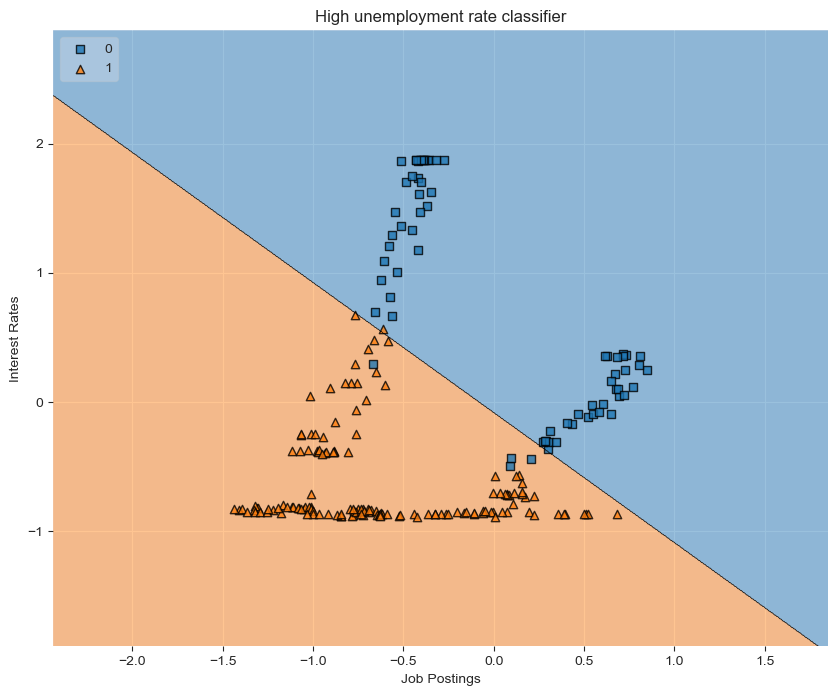

In [193]:
plot_X = train_X[:, [1, 3]] # job_postings and interest_rate
plot_Y = train_Y.to_numpy().ravel()
clf2 = SVC(kernel='linear', C=1).fit(plot_X, plot_Y)

fig = plt.figure(figsize=(10,8))
fig = plot_decision_regions(X=plot_X, y=plot_Y,
                            clf=clf2, legend=2)
plt.xlabel('Job Postings')
plt.ylabel('Interest Rates')
plt.title('High unemployment rate classifier')
plt.show()